In [1]:
from pymongo import MongoClient
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import re
import time
from datetime import datetime
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import warnings
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from sklearn import metrics
#Increase precision of numpy
np.finfo(np.longdouble).precision
# To suppress all user warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['DM_Project']
collection = db['Games']

In [3]:
# Convert the collection to Dataframe
df = pd.DataFrame(list(collection.find()))

In [4]:
#Display first rows of the Dataframe
display(df.head())


,_id,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,...,Screenshots,Movies,update_successful,updated,Support email,Support url,Notes,Reviews,Metacritic url,Score rank
0,65a4244006426426b396445b,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,...,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,True,True,NaN,NaN,NaN,NaN,NaN,NaN
1,65a4244006426426b396445c,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,...,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,True,True,support@rustymoyher.com,NaN,NaN,NaN,NaN,NaN
2,65a4244006426426b396445d,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,...,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,True,True,ramoncampiaof31@gmail.com,NaN,NaN,NaN,NaN,NaN
3,65a4244006426426b396445e,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,...,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,True,True,info@henosisgame.com,https://henosisgame.com/,NaN,NaN,NaN,NaN
4,65a4244006426426b396445f,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,...,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,True,True,welistentoyou@unusual-games.com,https://www.unusual-games.com/contact/,This Game may contain content not appropriate ...,NaN,NaN,NaN


In [5]:
display(df.describe())

,AppID,Peak CCU,Required age,Price,DLC count,Metacritic score,User score,Positive,Negative,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Score rank
count,8.356000e+04,83560.000000,83560.000000,83560.000000,83560.000000,83560.000000,83560.000000,8.356000e+04,83560.000000,83560.000000,8.356000e+04,83560.000000,83560.000000,83560.000000,83560.000000,44.000000
mean,1.334063e+06,136.292149,0.316563,7.195325,0.551795,3.408270,0.040558,8.384838e+02,123.314876,20.083772,7.894248e+02,106.641204,10.854931,95.016599,11.656498,98.909091
std,6.814413e+05,5450.778195,2.267967,12.312332,13.846870,15.551867,1.807466,1.767732e+04,3599.077791,172.998788,1.805742e+04,1152.854945,190.540115,1524.560676,207.227074,0.857747
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,97.000000
25%,7.630450e+05,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,98.000000
50%,1.304165e+06,0.000000,0.000000,4.490000,0.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,99.000000
75%,1.886992e+06,1.000000,0.000000,9.990000,0.000000,0.000000,0.000000,3.900000e+01,12.000000,18.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,100.000000
max,2.719700e+06,872138.000000,21.000000,999.980000,2366.000000,97.000000,100.000000,3.519727e+06,759795.000000,9821.000000,3.441592e+06,145727.000000,19159.000000,208473.000000,19159.000000,100.000000


In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83560 entries, 0 to 83559
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         83560 non-null  object 
 1   AppID                       83560 non-null  int64  
 2   Name                        83560 non-null  object 
 3   Release date                83560 non-null  object 
 4   Estimated owners            83560 non-null  object 
 5   Peak CCU                    83560 non-null  int64  
 6   Required age                83560 non-null  int64  
 7   Price                       83560 non-null  float64
 8   DLC count                   83560 non-null  int64  
 9   About the game              80122 non-null  object 
 10  Supported languages         83560 non-null  object 
 11  Full audio languages        83560 non-null  object 
 12  Header image                83560 non-null  object 
 13  Website                     390

None

In [7]:
display(df.isnull().sum(axis = 0))

_id                               0
AppID                             0
Name                              0
Release date                      0
Estimated owners                  0
Peak CCU                          0
Required age                      0
Price                             0
DLC count                         0
About the game                 3438
Supported languages               0
Full audio languages              0
Header image                      0
Website                       44506
Windows                           0
Mac                               0
Linux                             0
Metacritic score                  0
User score                        0
Positive                          0
Negative                          0
Achievements                      0
Recommendations                   0
Average playtime forever          0
Average playtime two weeks        0
Median playtime forever           0
Median playtime two weeks         0
Developers                  

In [8]:
#Check for duplicate games in the dataset
print(df['AppID'].nunique())

83560


In [9]:
display(df[df['Name'].isna()])

,_id,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,...,Screenshots,Movies,update_successful,updated,Support email,Support url,Notes,Reviews,Metacritic url,Score rank


In [10]:
#Visualize null rows
selected_rows = df[df['Categories'].isna() & df['Genres'].isna() & df['Tags'].isna()]
selected_rows

,_id,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,...,Screenshots,Movies,update_successful,updated,Support email,Support url,Notes,Reviews,Metacritic url,Score rank
4707,65a4244106426426b39656be,1678080,Missing - The Complete Saga Playtest,"Nov 16, 2021",0 - 0,0,0,0.0,0,NaN,...,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
5554,65a4244106426426b3965a0d,1836610,Adarin Farm Playtest,"Nov 30, 2021",0 - 0,0,0,0.0,0,NaN,...,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
6893,65a4244206426426b3965f48,1885600,Paws and Leaves - A Thracian Tale Playtest,"Jan 24, 2022",0 - 0,0,0,0.0,0,NaN,...,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
8855,65a4244206426426b39666f2,1911810,The Cruel Dreamer Marchosias Playtest,"Feb 18, 2022",0 - 0,0,0,0.0,0,NaN,...,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
9135,65a4244206426426b396680a,1725250,PIGGY: Hunt Playtest,"Oct 13, 2021",0 - 0,0,0,0.0,0,NaN,...,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82902,65a4245206426426b3978831,2129930,MORTARMEN Playtest,"Aug 23, 2023",0 - 0,0,0,0.0,0,NaN,...,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
83115,65a4245206426426b3978906,2670410,Twin Gods Playtest,"Nov 14, 2023",0 - 0,0,0,0.0,0,NaN,...,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
83543,65a4245206426426b3978ab2,2704600,Grønland Playtest,"Nov 24, 2023",0 - 0,0,0,0.0,0,NaN,...,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN
83547,65a4245206426426b3978ab6,2607070,Tower Song Playtest,"Sep 21, 2023",0 - 0,0,0,0.0,0,NaN,...,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
dfOS= df[['Windows','Mac','Linux']].copy()

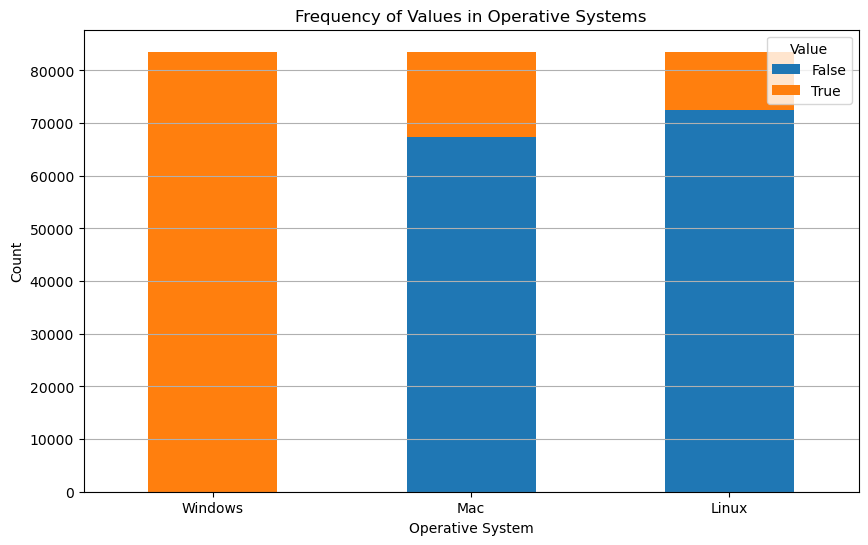

In [12]:
# Counting True and False occurrences in each column
count_df = dfOS.apply(pd.value_counts)

# Plotting
count_df.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Frequency of Values in Operative Systems')
plt.ylabel('Count')
plt.xlabel('Operative System')
plt.xticks(rotation=0)  # Rotates X-axis labels for readability
plt.legend(title='Value')
plt.grid(axis='y')
plt.show()

In [13]:
languages={}
for e in df['Supported languages']:
    clean = str(e).replace('\'','').replace(' ','').replace(']','').replace('[','').split(',')
    for l in clean:
        if l not in languages:
            languages[l] = 1
        else:
            languages[l]+=1

In [14]:
len(languages)

133

In [15]:
tmp = sorted(languages.items(), key=lambda x:x[1], reverse = True)[:10]

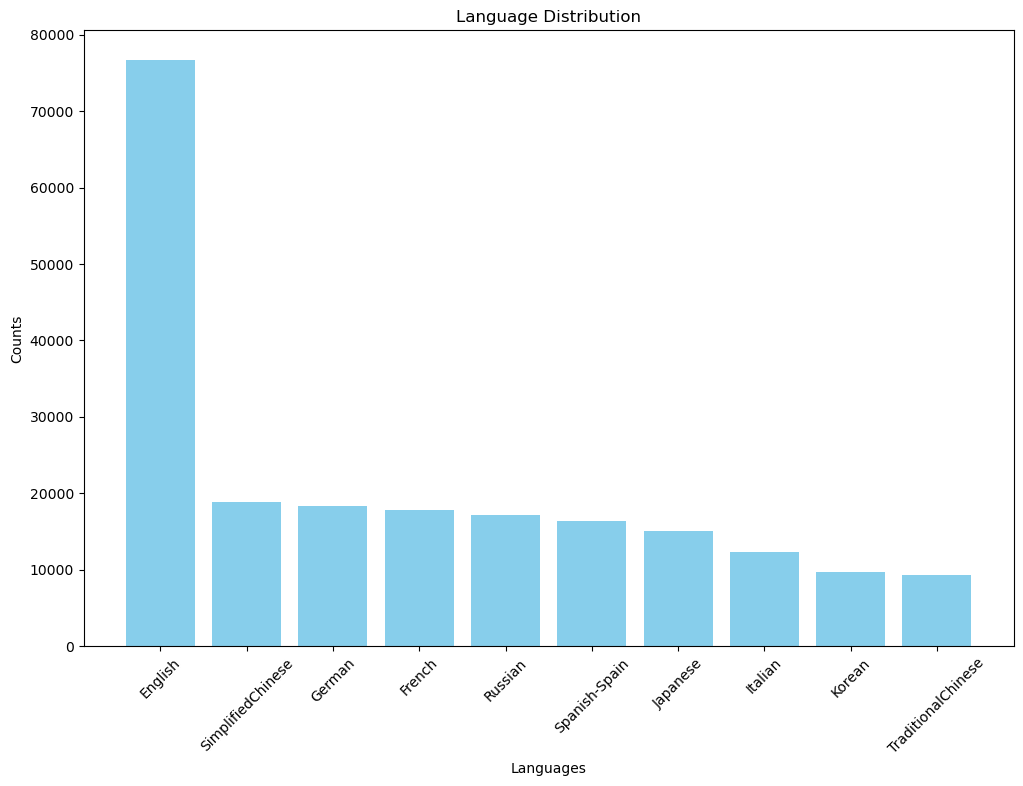

In [16]:
languages, counts = zip(*tmp)

# Creating the bar chart for the language distribution
plt.figure(figsize=(12, 8))
plt.bar(languages, counts, color='skyblue')
plt.xlabel('Languages')
plt.ylabel('Counts')
plt.title('Language Distribution')
plt.xticks(rotation=45)
plt.show()

In [17]:
clean_df = df.drop(['Score rank', 'Metacritic url', 'Reviews', 'Notes', 'Website', 'Support url', 'Support email', 'Movies', 'Screenshots', 'Publishers', 'Developers', 'About the game', 'Required age', 'Full audio languages', 'Supported languages', 'Windows', 'Mac', 'Linux', 'Header image', 'Metacritic score', 'Achievements', 'Recommendations', 'Median playtime forever', 'Median playtime two weeks','DLC count','User score','update_successful','updated'], axis=1).copy()

In [18]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83560 entries, 0 to 83559
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         83560 non-null  object 
 1   AppID                       83560 non-null  int64  
 2   Name                        83560 non-null  object 
 3   Release date                83560 non-null  object 
 4   Estimated owners            83560 non-null  object 
 5   Peak CCU                    83560 non-null  int64  
 6   Price                       83560 non-null  float64
 7   Positive                    83560 non-null  int64  
 8   Negative                    83560 non-null  int64  
 9   Average playtime forever    83560 non-null  int64  
 10  Average playtime two weeks  83560 non-null  int64  
 11  Categories                  83296 non-null  object 
 12  Genres                      83386 non-null  object 
 13  Tags                        635

In [19]:
#Drop rows where categories,genres and tags are all Nan
clean_df = clean_df.drop(clean_df[(clean_df['Categories'].isna()) & (clean_df['Genres'].isna()) & (clean_df['Tags'].isna())].index)

In [20]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83392 entries, 0 to 83559
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         83392 non-null  object 
 1   AppID                       83392 non-null  int64  
 2   Name                        83392 non-null  object 
 3   Release date                83392 non-null  object 
 4   Estimated owners            83392 non-null  object 
 5   Peak CCU                    83392 non-null  int64  
 6   Price                       83392 non-null  float64
 7   Positive                    83392 non-null  int64  
 8   Negative                    83392 non-null  int64  
 9   Average playtime forever    83392 non-null  int64  
 10  Average playtime two weeks  83392 non-null  int64  
 11  Categories                  83296 non-null  object 
 12  Genres                      83386 non-null  object 
 13  Tags                        63574 no

In [21]:
#Drop rows where the Name is Nan
clean_df = clean_df.drop(clean_df[clean_df['Name'].isna()].index)

In [22]:
clean_df['Estimated owners'].unique()

array(['0 - 20000', '50000 - 100000', '20000 - 50000', '200000 - 500000',
       '100000 - 200000', '2000000 - 5000000', '0 - 0',
       '500000 - 1000000', '1000000 - 2000000', '20000000 - 50000000',
       '5000000 - 10000000', '10000000 - 20000000',
       '50000000 - 100000000', '100000000 - 200000000'], dtype=object)

In [23]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83392 entries, 0 to 83559
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         83392 non-null  object 
 1   AppID                       83392 non-null  int64  
 2   Name                        83392 non-null  object 
 3   Release date                83392 non-null  object 
 4   Estimated owners            83392 non-null  object 
 5   Peak CCU                    83392 non-null  int64  
 6   Price                       83392 non-null  float64
 7   Positive                    83392 non-null  int64  
 8   Negative                    83392 non-null  int64  
 9   Average playtime forever    83392 non-null  int64  
 10  Average playtime two weeks  83392 non-null  int64  
 11  Categories                  83296 non-null  object 
 12  Genres                      83386 non-null  object 
 13  Tags                        63574 no

In [24]:
clean_df['Categories']

0        [Single-player, Multi-player, Steam Achievemen...
1        [Single-player, Steam Achievements, Full contr...
2                                          [Single-player]
3                 [Single-player, Full controller support]
4                      [Single-player, Steam Achievements]
                               ...                        
83555    [Single-player, Steam Achievements, Steam Lead...
83556                  [Single-player, Steam Achievements]
83557                  [Single-player, Steam Achievements]
83558                                      [Single-player]
83559                  [Single-player, Steam Achievements]
Name: Categories, Length: 83392, dtype: object

In [27]:
clean_df['Categories'].fillna("", inplace = True)
clean_df['Genres'].fillna("", inplace = True)
clean_df['Tags'].fillna("", inplace = True)

In [32]:
%%script false
#Combining 'Categories','Genres','Tags' and dropping them
clean_df['Combined tags'] = clean_df.apply(lambda row: row['Categories'].split(',') + row['Genres'].split(',') + row['Tags'].split(','), axis=1)
clean_df = clean_df.drop(['Categories','Genres','Tags'], axis=1)

Couldn't find program: 'false'


In [33]:
%%script false
#Removing duplicates from the combined columns
clean_df['Combined tags'] = clean_df['Combined tags'].apply(lambda x: list(set(x)))
clean_df['Combined tags'][0]

Couldn't find program: 'false'


In [34]:
#Average the string range of Estimated owners
def process_row(row):
    parts = row.replace(' ', '').split('-')
    return int((int(parts[0]) + int(parts[1])) / 2)
clean_df['Estimated owners'] = clean_df['Estimated owners'].apply(process_row)

# Outlier Detection


In [35]:
id_max_neg = clean_df['Negative'].idxmax()
id_max_pos = clean_df['Positive'].idxmax()

### Game with highest positive (Counter-Strike: Global Offensive)

_id                                                    65a4244b06426426b396f8a9
AppID                                                                       730
Name                                                           Counter-Strike 2
Release date                                                       Aug 21, 2012
Estimated owners                                                       75000000
Peak CCU                                                                 825215
Price                                                                       0.0
Positive                                                                3519727
Negative                                                                 524152
Average playtime forever                                                  30484
Average playtime two weeks                                                  777
Categories                    [Для нескольких игроков, Кроссплатформенная иг...
Genres                                  

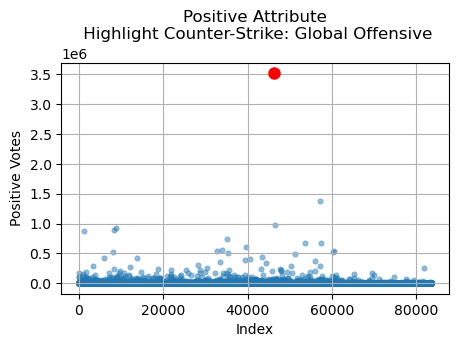

In [36]:
print(clean_df.loc[id_max_pos])
plt.figure(figsize=(5, 3))
plt.scatter(clean_df['Positive'].index,clean_df['Positive'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(id_max_pos, clean_df.loc[id_max_pos, 'Positive'], marker='o', markersize=8, color='red',alpha = 1)  
plt.title('Positive Attribute\n Highlight Counter-Strike: Global Offensive')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()

### Top Positive Games

In [37]:
pos_high_value_df = clean_df[clean_df['Positive'] > 1000000]
display(pos_high_value_df)

,_id,AppID,Name,Release date,Estimated owners,Peak CCU,Price,Positive,Negative,Average playtime forever,Average playtime two weeks,Categories,Genres,Tags
46158,65a4244b06426426b396f8a9,730,Counter-Strike 2,"Aug 21, 2012",75000000,825215,0.0,3519727,524152,30484,777,"[Для нескольких игроков, Кроссплатформенная иг...","[Экшены, Бесплатно]","FPS,Shooter,Multiplayer,Competitive,Action,Tea..."
57205,65a4244d06426426b39723d0,271590,Grand Theft Auto V,"Apr 13, 2015",35000000,170527,0.0,1376538,207006,13650,656,"[Single-player, Multi-player, PvP, Online PvP,...","[Action, Adventure]","Open World,Action,Multiplayer,Automobile Sim,C..."


_id                                                    65a4244b06426426b396f8a9
AppID                                                                       730
Name                                                           Counter-Strike 2
Release date                                                       Aug 21, 2012
Estimated owners                                                       75000000
Peak CCU                                                                 825215
Price                                                                       0.0
Positive                                                                3519727
Negative                                                                 524152
Average playtime forever                                                  30484
Average playtime two weeks                                                  777
Categories                    [Для нескольких игроков, Кроссплатформенная иг...
Genres                                  

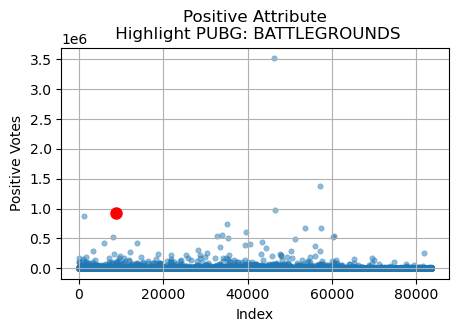

In [38]:
print(clean_df.loc[id_max_pos])
plt.figure(figsize=(5, 3))
plt.scatter(clean_df['Positive'].index,clean_df['Positive'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(id_max_neg, clean_df.loc[id_max_neg, 'Positive'], marker='o', markersize=8, color='red')  
plt.title('Positive Attribute\n Highlight PUBG: BATTLEGROUNDS')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()

### Second highest positive game (Grand Theft Auto V)

_id                                                    65a4244d06426426b39723d0
AppID                                                                    271590
Name                                                         Grand Theft Auto V
Release date                                                       Apr 13, 2015
Estimated owners                                                       35000000
Peak CCU                                                                 170527
Price                                                                       0.0
Positive                                                                1376538
Negative                                                                 207006
Average playtime forever                                                  13650
Average playtime two weeks                                                  656
Categories                    [Single-player, Multi-player, PvP, Online PvP,...
Genres                                  

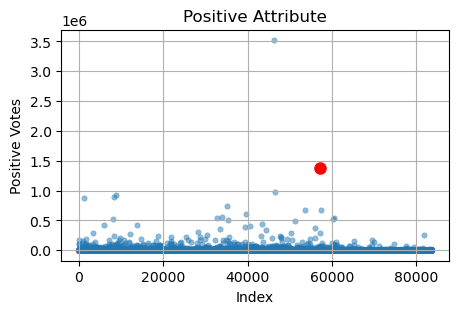

In [39]:
top2_pos = clean_df['Positive'].nlargest(2)
second_highest = top2_pos.index[-1]
print(clean_df.loc[57205])
plt.figure(figsize=(5, 3))
plt.scatter(clean_df['Positive'].index,clean_df['Positive'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(second_highest, clean_df.loc[second_highest, 'Positive'], marker='o', markersize=8, color='red')  
plt.title('Positive Attribute')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()

### Game with highest Negative votes (PUBG: BATTLEGROUNDS)

_id                                                    65a4244206426426b3966710
AppID                                                                    578080
Name                                                        PUBG: BATTLEGROUNDS
Release date                                                       Dec 21, 2017
Estimated owners                                                       75000000
Peak CCU                                                                 275374
Price                                                                       0.0
Positive                                                                 929599
Negative                                                                 759795
Average playtime forever                                                  21963
Average playtime two weeks                                                  790
Categories                    [Multi-player, PvP, Online PvP, Stats, Remote ...
Genres                        [Action, A

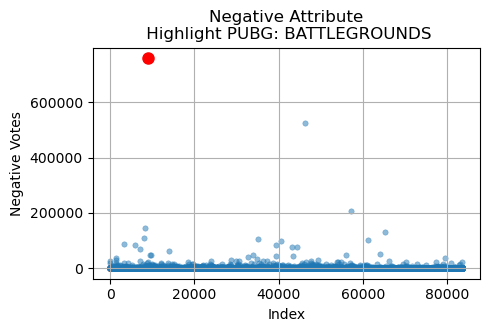

In [40]:
print(clean_df.loc[id_max_neg])
plt.figure(figsize=(5, 3))
plt.scatter(clean_df['Negative'].index,clean_df['Negative'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(id_max_neg, clean_df.loc[id_max_neg, 'Negative'], marker='o', markersize=8, color='red')  
plt.title('Negative Attribute\n Highlight PUBG: BATTLEGROUNDS')
plt.xlabel('Index')
plt.ylabel('Negative Votes')
plt.grid(True)
plt.show()

### Negative value plot for highest positive game (Counter-Strike: Global Offensive)

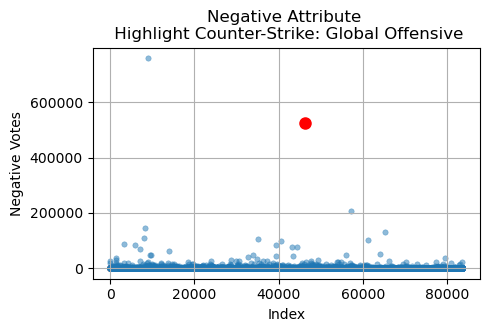

In [41]:
plt.figure(figsize=(5, 3))
plt.scatter(clean_df['Negative'].index,clean_df['Negative'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.plot(id_max_pos, clean_df.loc[id_max_pos, 'Negative'], marker='o', markersize=8, color='red')  
plt.title('Negative Attribute \n Highlight Counter-Strike: Global Offensive')
plt.xlabel('Index')
plt.ylabel('Negative Votes')
plt.grid(True)
plt.show()

### Games with more than 200k Negative votes

In [48]:
neg_high_value_df = clean_df[clean_df['Negative'] > 125000]
display(neg_high_value_df)

,_id,AppID,Name,Release date,Estimated owners,Peak CCU,Price,Positive,Negative,Average playtime forever,Average playtime two weeks,Categories,Genres,Tags
8256,65a4244206426426b396649b,359550,Tom Clancy's Rainbow Six® Siege,"Dec 1, 2015",35000000,42263,19.99,895356,144786,13837,707,"[Single-player, Multi-player, PvP, Online PvP,...",[Action],"FPS,Hero Shooter,Multiplayer,Tactical,Shooter,..."
8885,65a4244206426426b3966710,578080,PUBG: BATTLEGROUNDS,"Dec 21, 2017",75000000,275374,0.00,929599,759795,21963,790,"[Multi-player, PvP, Online PvP, Stats, Remote ...","[Action, Adventure, Massively Multiplayer, Fre...","Survival,Shooter,Multiplayer,Battle Royale,FPS..."
46158,65a4244b06426426b396f8a9,730,Counter-Strike 2,"Aug 21, 2012",75000000,825215,0.00,3519727,524152,30484,777,"[Для нескольких игроков, Кроссплатформенная иг...","[Экшены, Бесплатно]","FPS,Shooter,Multiplayer,Competitive,Action,Tea..."
57205,65a4244d06426426b39723d0,271590,Grand Theft Auto V,"Apr 13, 2015",35000000,170527,0.00,1376538,207006,13650,656,"[Single-player, Multi-player, PvP, Online PvP,...","[Action, Adventure]","Open World,Action,Multiplayer,Automobile Sim,C..."
65186,65a4244f06426426b39742fd,1938090,Call of Duty®,"Oct 27, 2022",3500000,233454,69.99,161207,132425,787,787,"[Single-player, Multi-player, PvP, Online PvP,...",[Action],"FPS,Action,Multiplayer,Shooter,Military,First-..."


In [52]:
neg_high_value_df['Estimated owners'].sum()

223500000

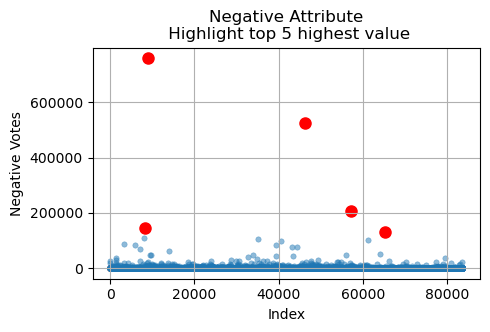

In [50]:
plt.figure(figsize=(5, 3))
plt.scatter(clean_df['Negative'].index,clean_df['Negative'], marker='o', linewidth=0.4,alpha=0.5,s=15) 
plt.scatter(neg_high_value_df.index, neg_high_value_df['Negative'], color='red', s=64)  # s is the size of the points 
plt.title('Negative Attribute\n Highlight top 5 highest value')
plt.xlabel('Index')
plt.ylabel('Negative Votes')
plt.grid(True)
plt.show()

### Normal distribution for the positive attribute ( log reduced )

In [ ]:
log_plot_df = clean_df.copy()
log_plot_df['Log_Positive'] = np.log(log_plot_df['Positive'] + 1)
mean = log_plot_df['Log_Positive'].mean()
std = log_plot_df['Log_Positive'].std()
range_values = np.linspace(mean - 3*std, mean + 3*std, 100)
normal_distr_curve = norm.pdf(range_values, mean, std)
plt.figure(figsize=(5, 3))
plt.hist(log_plot_df['Log_Positive'] , bins=30, density=True, alpha=0.6,edgecolor='black')
plt.plot(range_values, normal_distr_curve, 'r-', lw=2)
plt.title('Normal Distribution for Positive Attribute')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## Winsorization of outliers

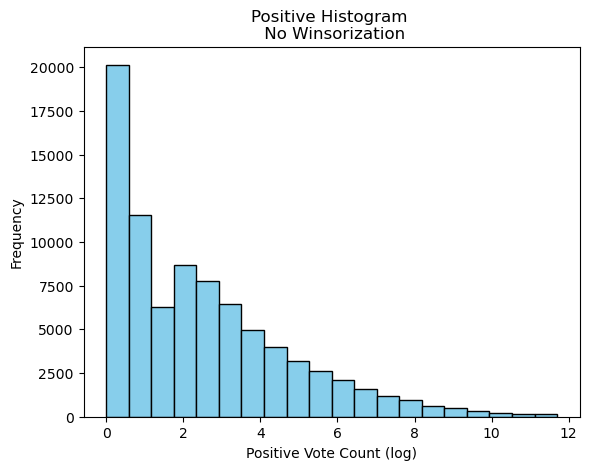

In [58]:
#Positive histogram no winsorization
test_df=clean_df.copy()
# Add 1 to 0 values
test_df['Log_Positive'] = np.where(test_df['Positive'] == 0, test_df['Positive'] + 1, test_df['Positive'])
#Apply log
test_df['Log_Positive'] = np.log(test_df['Log_Positive'])
plt.hist(test_df['Log_Positive'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Positive Vote Count (log)')
plt.ylabel('Frequency')
plt.title('Positive Histogram \n No Winsorization')
plt.show()

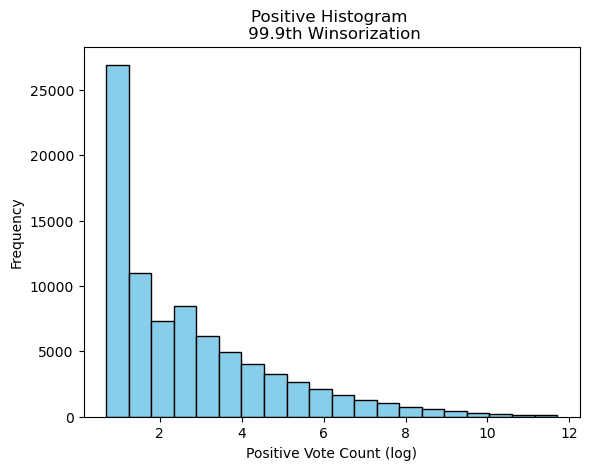

In [59]:
#Winsorize at 99.9th percentile right side only
test_df['Winsorized Positive'] = winsorize(test_df['Positive'], limits=[0, 0.001])
# Add 1 to 0 values
test_df['Log_WinPositive'] = np.where(test_df['Winsorized Positive'] == 0, test_df['Winsorized Positive'] + 1, test_df['Winsorized Positive'])
#Apply log
test_df['Log_WinPositive'] = np.log(test_df['Log_WinPositive'])
test_df['Log_WinPositive'] = np.log(test_df['Winsorized Positive'] + 1)
plt.hist(test_df['Log_WinPositive'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Positive Vote Count (log)')
plt.ylabel('Frequency')
plt.title('Positive Histogram \n 99.9th Winsorization')
plt.show()

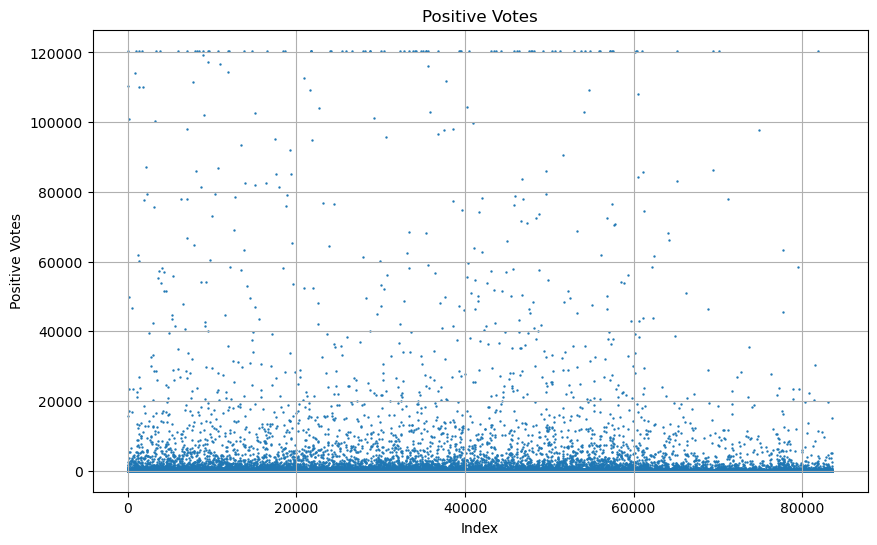

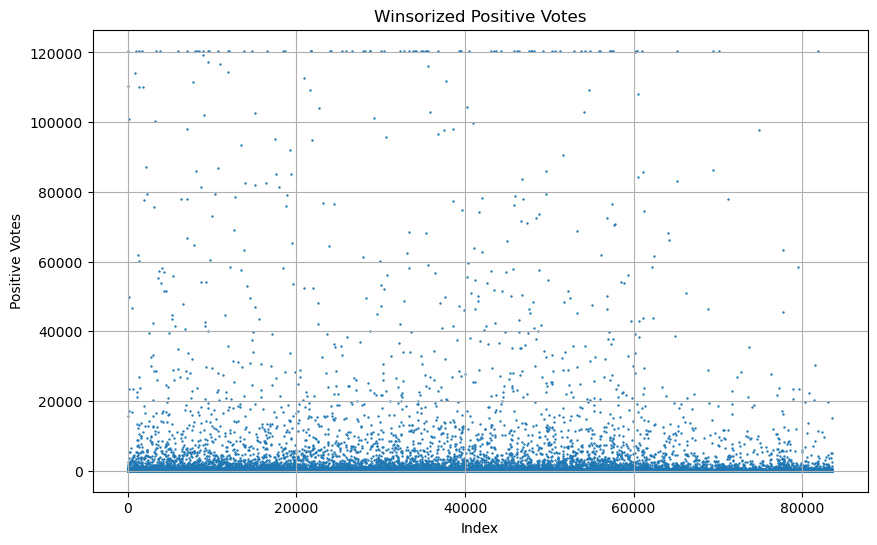

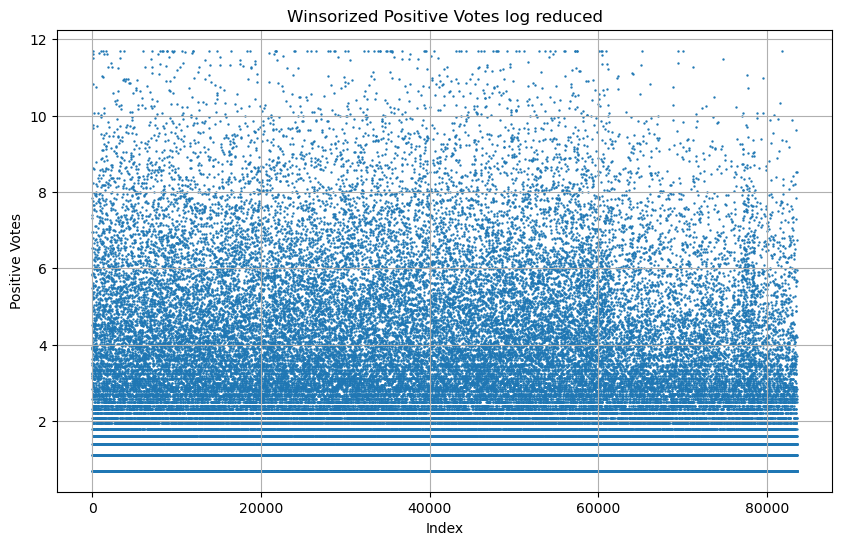

In [60]:
#Plotting entries by Positive attribute
plt.figure(figsize=(10, 6))
plt.scatter(test_df['Positive'].index,test_df['Positive'], marker='o',s = 0.5) 
plt.title('Positive Votes')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()
#Plotting entries by Winsorized Positive attribute
plt.figure(figsize=(10, 6))
plt.scatter(test_df['Winsorized Positive'].index,test_df['Winsorized Positive'], marker='o',s=0.5) 
plt.title('Winsorized Positive Votes')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()
#Plotting entries by Log Reduced Winsorized Positive attribute
plt.figure(figsize=(10, 6))
plt.scatter(test_df['Log_WinPositive'].index,test_df['Log_WinPositive'], marker='o',s=0.5) 
plt.title('Winsorized Positive Votes log reduced')
plt.xlabel('Index')
plt.ylabel('Positive Votes')
plt.grid(True)
plt.show()





## Net votes z-score

In [ ]:
# Calculate net z-score
mean_net = (clean_df['Positive'] - clean_df['Negative']).mean()
std_dev_net = (clean_df['Positive'] - clean_df['Negative']).std()
clean_df['Net Votes zscore'] = ((clean_df['Positive'] - clean_df['Negative']) - mean_net) / std_dev_net
#clean_df = clean_df.drop(['Positive','Negative'],axis=1)


### Winsorization of original dataset attributes

In [53]:
pre_log_clean_df = clean_df.copy()

In [55]:
# Add 1 to 0 values and apply log
def apply_log(Attr):
    Attr = np.where(Attr == 0, Attr + 1, Attr)
    #Apply log
    return np.log(Attr)

In [ ]:
#Apply Winsorization
clean_df['Positive'] = (winsorize(clean_df['Positive'], limits=[0, 0.001])+1)
clean_df['Negative'] = (winsorize(clean_df['Negative'], limits=[0, 0.001])+1)
clean_df['Average playtime forever'] =( winsorize(clean_df['Average playtime forever'], limits=[0, 0.001])+1)
clean_df['Average playtime two weeks'] = (winsorize(clean_df['Average playtime two weeks'], limits=[0, 0.001])+1)
clean_df['Estimated owners'] = (winsorize(clean_df['Estimated owners'], limits=[0, 0.001]))
clean_df['Peak CCU'] = (winsorize(clean_df['Peak CCU'], limits=[0, 0.001])+1)
clean_df['Net Votes zscore'] = (winsorize(clean_df['Net Votes zscore'], limits=[0, 0.001]))
clean_df['Price'] = (winsorize(clean_df['Price'], limits=[0, 0.001]))

#Apply log
clean_df['Positive'] = apply_log(clean_df['Positive'] )
clean_df['Negative'] = apply_log(clean_df['Negative'])
clean_df['Average playtime forever'] =apply_log(clean_df['Average playtime forever'])
clean_df['Average playtime two weeks'] =apply_log(clean_df['Average playtime two weeks'])
clean_df['Estimated owners'] =apply_log(clean_df['Estimated owners'])
clean_df['Peak CCU'] = apply_log(clean_df['Peak CCU'] )
#clean_df['Net Votes zscore'] = apply_log(clean_df['Net Votes zscore'])
clean_df['Price'] =apply_log(clean_df['Price'])

### Date to days passed

In [ ]:
#Convert Release date to elapsed days
def dateToDaysPassed(row):
    if ',' in row:
        splitdate = row.split(',')
        date = re.sub(r'[0-9]', '', splitdate[0]).replace(' ','') +'-'+splitdate[1].replace(' ','')
        d = (datetime.now() - datetime.fromtimestamp(datetime.timestamp(datetime.strptime(date, "%b-%Y")))).days
        if d<0: d=0
        return d
    else:
        splitdate = row.split(' ')
        date = re.sub(r'[0-9]', '', splitdate[0]).replace(' ','') +'-'+splitdate[1].replace(' ','')
        d = (datetime.now() - datetime.fromtimestamp(datetime.timestamp(datetime.strptime(date, "%b-%Y")))).days
        if d<0: d=0
        return d
clean_df['Days gone']=clean_df['Release date'].apply(dateToDaysPassed)
clean_df = clean_df.drop(['Release date'],axis=1)

## Exploratory data analysis

### Analyze 60000 index mark

In [ ]:
test_df = clean_df.copy()
test_df['Tot votes'] = (test_df['Positive'] + test_df['Negative']).copy()
plt.figure(figsize=(10, 6))
plt.scatter(clean_df.index, test_df['Tot votes'], alpha=0.5,s=1.5)

plt.scatter(test_df['Tot votes'].index[60000:74000], test_df['Tot votes'][60000:74000], color='red', alpha=0.5,s=1.5)

plt.title('Total number of Votes \n(Positive and Negative)')
plt.xlabel('Index')
plt.ylabel('Tot Votes')
plt.show()

blue_df = pd.concat([test_df[:60000],test_df[74000:]])
red_df = test_df[60000:74000]

print('_'*100)
print('\033[94m' + "Blue stats\n")
print(blue_df.describe())

print('_'*100)

print('\033[91m'+"Red stats\n")
print(red_df.describe())

### Net Z-score and Positive Ratio (original df) plot

In [ ]:
#Plot Net votes zscore / totvotes
plt.figure(figsize=(5, 3))
plt.scatter(clean_df['Net Votes zscore'], (pre_log_clean_df['Positive']+pre_log_clean_df['Negative']), alpha=0.5,s=2)
plt.title('Total Votes vs Net z-score')
plt.xlabel('Net z-score')
plt.ylabel('Total Votes')
plt.ylim(0,300000)
plt.xlim(0,None)
plt.grid(True)
plt.show()
#Plot Positive ratio / totvotes
plt.figure(figsize=(5, 3))
plt.scatter(df['Positive']/(df['Positive']+df['Negative']),(df['Positive']+df['Negative']), alpha=0.5,s=5)
plt.title('Total Votes vs Positive ratio')
plt.xlabel('Positive Ratio')
plt.ylabel('Total Votes')
plt.ylim(0,300000)
plt.grid(True)
plt.show()

## Correlation Analysis

In [ ]:
EDA_df = clean_df.copy()
EDA_df = EDA_df.drop(['_id','AppID'],axis=1)
pd.options.display.float_format = "{:.2f}".format
EDA_df.describe()

### Correlation matrix

In [ ]:
#Correlation analysis
correlation_matrix = EDA_df[['Positive', 'Negative', 'Net Votes zscore', 'Average playtime forever', 'Average playtime two weeks','Price','Peak CCU','Estimated owners','Days gone']].corr()
display(correlation_matrix)

### Pearson Coefficient

In [ ]:
#Correlation analysis - Pearson correlation coefficient

correlation_df = clean_df.copy()
correlation_df = correlation_df.drop(['_id','AppID','Name','Combined tags'],axis=1)

#Defining a function for Pearson Coefficient
def pearsonCorrelation(A,B):
    A_mean = A.mean()
    B_mean = B.mean()
    A_std = A.std()
    B_std = B.std()
    return (((A - A_mean) * (B - B_mean)).sum())/(len(A)*A_std*B_std)


In [ ]:
#Correlation analysis - Plot function
def plotCouples(candidates):
    for c in candidates:
        
        print('_'*20)
        print(c[0]+"/"+c[1]+ "  " + str(c[2]))

        plt.figure(figsize=(5, 3))
        plt.scatter(correlation_df[c[0]], correlation_df[c[1]],alpha=0.5,s=2)
        plt.title(c[0]+'/'+c[1]+'  ' +str(c[2]))
        plt.xlabel(c[0])
        plt.ylabel(c[1])
        plt.grid(True)
        plt.show()

In [ ]:
#Iterate all the attribute combination and calculate pearson coefficient
attributes = list(correlation_df.columns.values)
candidates = []
for i, attr1 in enumerate(attributes):
    for attr2 in attributes[i + 1:]:
        r=pearsonCorrelation(correlation_df[attr1],correlation_df[attr2])
        if r>=0.5 or r<= -0.3:
            #print('\033[92m' + attr1 + " / " + attr2 +": " + str(r))
            candidates.append([attr1,attr2,r])
#Sort candidate list descending
candidates = sorted(candidates, key=lambda x:x[2],reverse=True)
#Print candidates
candidates_df = pd.DataFrame(candidates, columns=['Attribute 1', 'Attribute 2', 'Pearson Coefficient'])
display(candidates_df)
#Plot candidates
plotCouples(candidates)

### Covariance Analysis


In [ ]:
#Normalize estimated owners, price and days gone between 0 and 1 for covariance calculation
correlation_df['Estimated owners'] = (correlation_df['Estimated owners'] - correlation_df['Estimated owners'].min()) / (correlation_df['Estimated owners'].max() - correlation_df['Estimated owners'].min())
correlation_df['Days gone'] =(correlation_df['Days gone'] - correlation_df['Days gone'].min()) / (correlation_df['Days gone'].max() - correlation_df['Days gone'].min())
correlation_df['Price'] = (correlation_df['Price'] - correlation_df['Price'].min()) / (correlation_df['Price'].max() - correlation_df['Price'].min())

In [ ]:
candidates_df

In [ ]:
#Iterate all the attribute combination and calculate covariance
attributes = list(correlation_df.columns.values)
candidates = []
for i, attr1 in enumerate(attributes):
    for attr2 in attributes[i + 1:]:
        r=correlation_df[attr1].cov(correlation_df[attr2])
        if r>=0.5 or r<= -0:
            #print('\033[92m' + attr1 + " / " + attr2 +": " + str(r))
            candidates.append([attr1,attr2,r])
            

#Sort candidate list descending
candidates = sorted(candidates, key=lambda x:x[2],reverse=True)
#Print candidates
candidates_df = pd.DataFrame(candidates, columns=['Attribute 1', 'Attribute 2', 'Covariance Coefficient'])
display(candidates_df)
#Plot candidates
plotCouples(candidates)

In [ ]:
%%script false
#Normalizing values between 0 and 1
clean_df['Estimated owners']=(clean_df['Estimated owners']-clean_df['Estimated owners'].min()+1)/(clean_df['Estimated owners'].max()-clean_df['Estimated owners'].min()+1)
clean_df['Peak CCU']=(clean_df['Peak CCU']-clean_df['Peak CCU'].min()+1)/(clean_df['Peak CCU'].max()-clean_df['Peak CCU'].min()+1)
clean_df['Price']=(clean_df['Price']-clean_df['Price'].min()+1)/(clean_df['Price'].max()-clean_df['Price'].min()+1)
clean_df['Positive']=(clean_df['Positive']-clean_df['Positive'].min()+1)/(clean_df['Positive'].max()-clean_df['Positive'].min()+1)
clean_df['Negative']=(clean_df['Negative']-clean_df['Negative'].min()+1)/(clean_df['Negative'].max()-clean_df['Negative'].min()+1)
clean_df['Average playtime forever']=(clean_df['Average playtime forever']-clean_df['Average playtime forever'].min()+1)/(clean_df['Average playtime forever'].max()-clean_df['Average playtime forever'].min()+1)
clean_df['Average playtime two weeks']=(clean_df['Average playtime two weeks']-clean_df['Average playtime two weeks'].min()+1)/(clean_df['Average playtime two weeks'].max()-clean_df['Average playtime two weeks'].min()+1)
clean_df['Net Votes']=(clean_df['Net Votes']-clean_df['Net Votes'].min()+1)/(clean_df['Net Votes'].max()-clean_df['Net Votes'].min()+1)
clean_df['Votes zscore']=(clean_df['Votes zscore']-clean_df['Votes zscore'].min()+1)/(clean_df['Votes zscore'].max()-clean_df['Votes zscore'].min()+1)
pd.options.display.float_format = "{:.6f}".format
clean_df.describe()

## Binary Encoding tags

In [ ]:
import category_encoders as ce
bin_df = clean_df.copy()
bin_df['Combined tags'] = bin_df['Combined tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
display(bin_df['Combined tags'])
encoder = ce.BinaryEncoder(cols=['Combined tags'])
df_encoded = encoder.fit_transform(bin_df['Combined tags'])
display(df_encoded)

## One-Hot Encoding tags

In [ ]:
%%script false
onehot_df = clean_df.copy()
#Join the tags in a single string
onehot_df['Combined tags'] = onehot_df['Combined tags'].apply(lambda x: ','.join(x))
#Inizialize the tokenizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
#Tranfsorm strings to one hot vectors
tags_encoded = vectorizer.fit_transform(onehot_df['Combined tags'])

In [ ]:
%%script false
#Check if some duplicate tags were left after the cleaning process
not_1 = tags_encoded.toarray() > 1
if not_1.any():
    indexes = np.where(not_1)
    if len(indexes)>0:
        #Sign function, values greater than 1 get set to 1
        tags_encoded = tags_encoded.sign()
#Put encoded matrix in dataframe
tags_df = pd.DataFrame(tags_encoded.toarray(), columns=vectorizer.get_feature_names_out())
#Drop empty tag
tags_df = tags_df.drop([''],axis=1)

## Dimensionality reduction

#### Remove Positive and Negative, use only the net votes

In [ ]:
clean_df = clean_df.drop(['Positive','Negative'], axis = 1)

In [ ]:
df_encoded.info()
clean_df.info()

#### Principal Component Analisys

In [ ]:
#Copying df without attributes that don't need scaling
scaling_df = clean_df.drop(['_id','AppID','Name','Combined tags'], axis=1)
scaling_df.index = clean_df.index
# Assuming that 'df_continuous' are the continuous features without the 'AppID'
scaledFeatures = StandardScaler().fit_transform(scaling_df.select_dtypes(include=[np.number]))
#Stacking features with one hot encoding
combined_features = np.hstack((scaledFeatures, df_encoded.values))
#set 95% of variance
pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(scaledFeatures)
# Convert the principal components into df
df_pca = pd.DataFrame(data=principal_components,columns=['PC' + str(i+1) for i in range(principal_components.shape[1])])  
df_pca.index = clean_df.index

In [ ]:
# Plot the explained variance 
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Principal component analysis\nExplained variance')
plt.show()
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1
print(n_components)